In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers

In [2]:
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [26]:
from google.colab import files

In [3]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "colorectal_histology",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
    shuffle_files= True,
)

num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteJAKH6A/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [4]:
size = (224, 224)
batch_size = 32

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),    
    layers.RandomRotation(0.1),
    ])

In [7]:
base_model = keras.applications.resnet_v2.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

94668760/94668760 [==============================] - 3s 0us/step


In [8]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [9]:
base_model.trainable = False

In [10]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

In [11]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [12]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True,
    verbose=1
    )

In [13]:
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [14]:
epochs = 500
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback])

Epoch 1/500
125/125 [==============================] - 33s 170ms/step - loss: 0.7527 - accuracy: 0.7370 - val_loss: 0.4386 - val_accuracy: 0.8600
Epoch 2/500
125/125 [==============================] - 16s 129ms/step - loss: 0.4121 - accuracy: 0.8600 - val_loss: 0.3756 - val_accuracy: 0.8800
Epoch 3/500
125/125 [==============================] - 16s 131ms/step - loss: 0.3518 - accuracy: 0.8817 - val_loss: 0.3369 - val_accuracy: 0.8820
Epoch 4/500
125/125 [==============================] - 17s 136ms/step - loss: 0.3299 - accuracy: 0.8815 - val_loss: 0.3337 - val_accuracy: 0.8840
Epoch 5/500
125/125 [==============================] - 16s 132ms/step - loss: 0.2995 - accuracy: 0.8967 - val_loss: 0.3232 - val_accuracy: 0.8820
Epoch 6/500
125/125 [==============================] - 16s 130ms/step - loss: 0.3032 - accuracy: 0.8938 - val_loss: 0.3104 - val_accuracy: 0.8880
Epoch 7/500
125/125 [==============================] - 16s 129ms/step - loss: 0.2857 - accuracy: 0.9030 - val_loss: 0.3196 -

In [15]:
score = model.evaluate(train_ds, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1637176275253296
Test accuracy: 0.9402499794960022


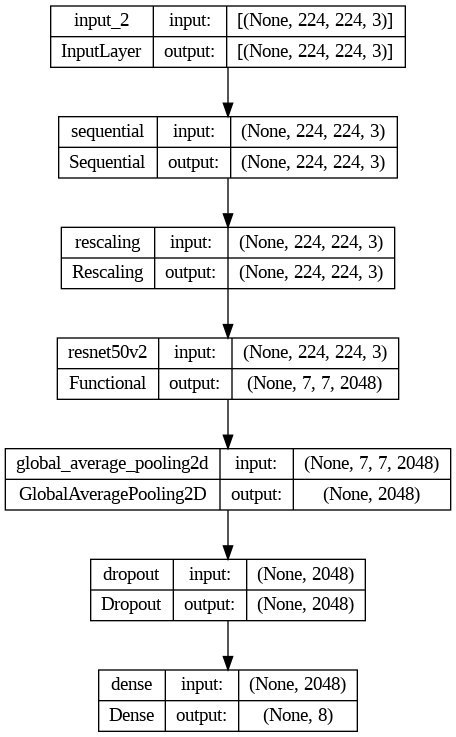

In [16]:
keras.utils.plot_model(model,show_shapes=True)

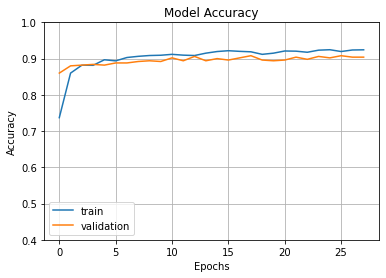

In [17]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     


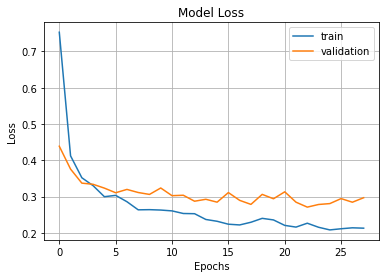

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [19]:
model.save('model.h5')

In [30]:
from google.colab import files
try:
  files.download('./model.h5')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Nueva sección

# Nueva sección